# Introduction to gimVI

## Imputing missing genes in spatial data from sequencing data with gimVI

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scipy.stats import spearmanr
from scvi.data import cortex, smfish
from scvi.external import GIMVI

/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
  """ Class for doing community detection using the Leiden algorithm.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invalid escape sequence '\s'
  """ Optimise the given partitions simultaneously.


/usr/local/lib/python3.12/site-packages/pyro/ops/stats.py:514: SyntaxWarning: invalid escape sequence '\g'
  """


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.6


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
train_size = 0.8
spatial_data = smfish(save_path=save_dir.name)
seq_data = cortex(save_path=save_dir.name)

INFO     Downloading file at /tmp/tmpyybvtiax/osmFISH_SScortex_mouse_all_cell.loom                                 


Downloading...:   0%|          | 0/1121.0 [00:00<?, ?it/s]

/usr/local/lib/python3.12/site-packages/loompy/view_manager.py:23: SyntaxWarning: "is not" with 'int' literal. Did you mean "!="?
  if type(slice_) is not tuple or len(slice_) is not 2:


INFO     Loading smFISH dataset                                                                                    


INFO     Downloading file at /tmp/tmpyybvtiax/expression.bin                                                       


Downloading...:   0%|          | 0/121129.0 [00:00<?, ?it/s]

INFO     Loading Cortex data from /tmp/tmpyybvtiax/expression.bin                                                  


INFO     Finished loading Cortex data                                                                              


/usr/local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Preparing the data

In this section, we hold out some of the genes in the spatial dataset in order to test the imputation results

In [6]:
# only use genes in both datasets
seq_data = seq_data[:, spatial_data.var_names].copy()

seq_gene_names = seq_data.var_names
n_genes = seq_data.n_vars
n_train_genes = int(n_genes * train_size)

# randomly select training_genes
rand_train_gene_idx = np.random.choice(range(n_genes), n_train_genes, replace=False)
rand_test_gene_idx = sorted(set(range(n_genes)) - set(rand_train_gene_idx))
rand_train_genes = seq_gene_names[rand_train_gene_idx]
rand_test_genes = seq_gene_names[rand_test_gene_idx]

# spatial_data_partial has a subset of the genes to train on
spatial_data_partial = spatial_data[:, rand_train_genes].copy()

# remove cells with no counts
sc.pp.filter_cells(spatial_data_partial, min_counts=1)
sc.pp.filter_cells(seq_data, min_counts=1)

# setup_anndata for spatial and sequencing data
GIMVI.setup_anndata(spatial_data_partial, labels_key="labels", batch_key="batch")
GIMVI.setup_anndata(seq_data, labels_key="labels")

# spatial_data should use the same cells as our training data
# cells may have been removed by scanpy.pp.filter_cells()
spatial_data = spatial_data[spatial_data_partial.obs_names]

## Creating the model and training

In [7]:
model = GIMVI(seq_data, spatial_data_partial)
model.train(max_epochs=200)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


## Analyzing the results

### Getting the latent representations and plotting UMAPs

In [8]:
# get the latent representations for the sequencing and spatial data
latent_seq, latent_spatial = model.get_latent_representation()

# concatenate to one latent representation
latent_representation = np.concatenate([latent_seq, latent_spatial])
latent_adata = anndata.AnnData(latent_representation)

# labels which cells were from the sequencing dataset and which were from the spatial dataset
latent_labels = (["seq"] * latent_seq.shape[0]) + (["spatial"] * latent_spatial.shape[0])
latent_adata.obs["labels"] = latent_labels

# compute umap
sc.pp.neighbors(latent_adata, use_rep="X")
sc.tl.umap(latent_adata)

# save umap representations to original seq and spatial_datasets
seq_data.obsm["X_umap"] = latent_adata.obsm["X_umap"][: seq_data.shape[0]]
spatial_data.obsm["X_umap"] = latent_adata.obsm["X_umap"][seq_data.shape[0] :]

/tmp/ipykernel_153/1264898024.py:18: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  spatial_data.obsm["X_umap"] = latent_adata.obsm["X_umap"][seq_data.shape[0] :]


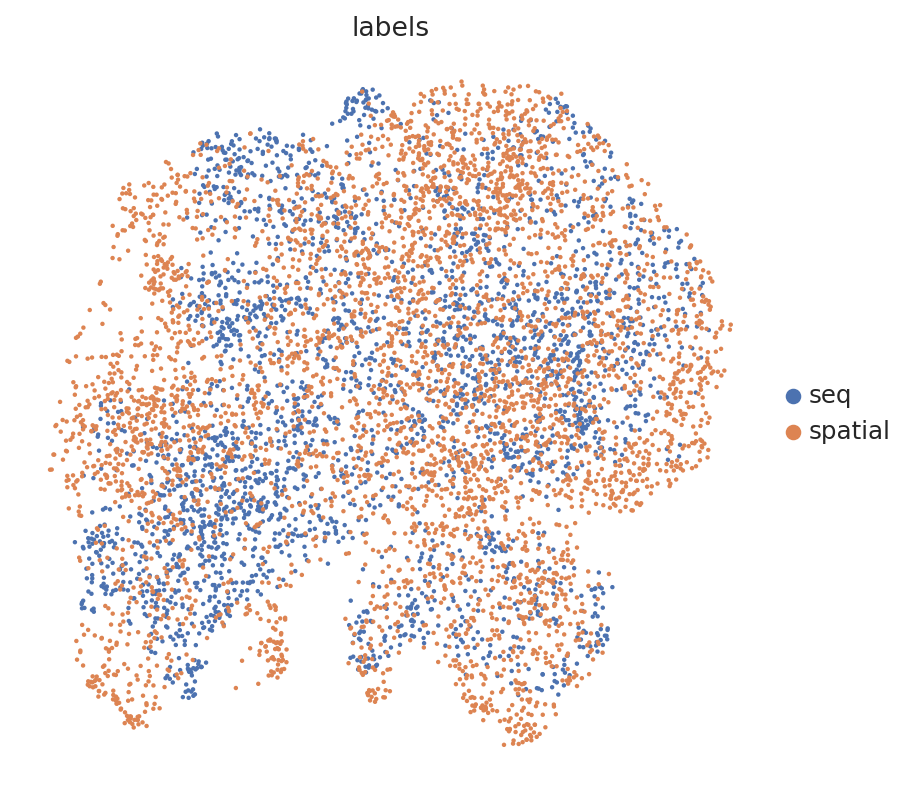

In [9]:
# umap of the combined latent space
sc.pl.umap(latent_adata, color="labels", show=True)

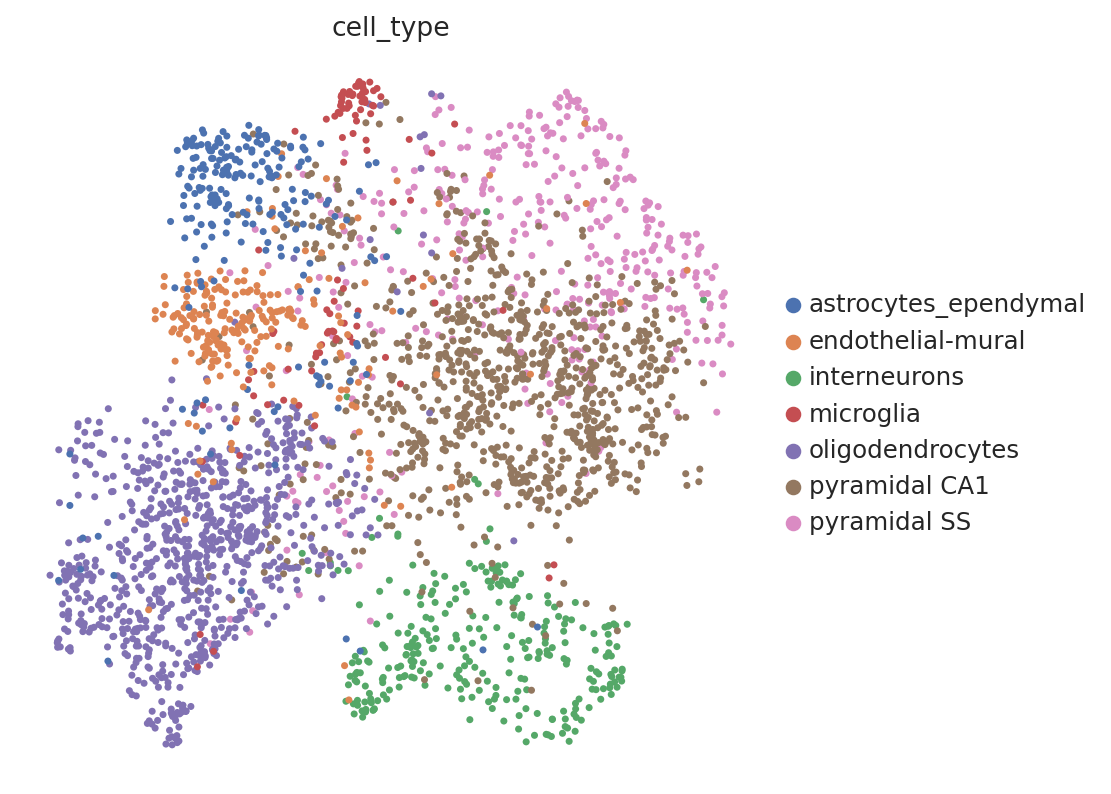

In [10]:
# umap of sequencing dataset
sc.pl.umap(seq_data, color="cell_type")

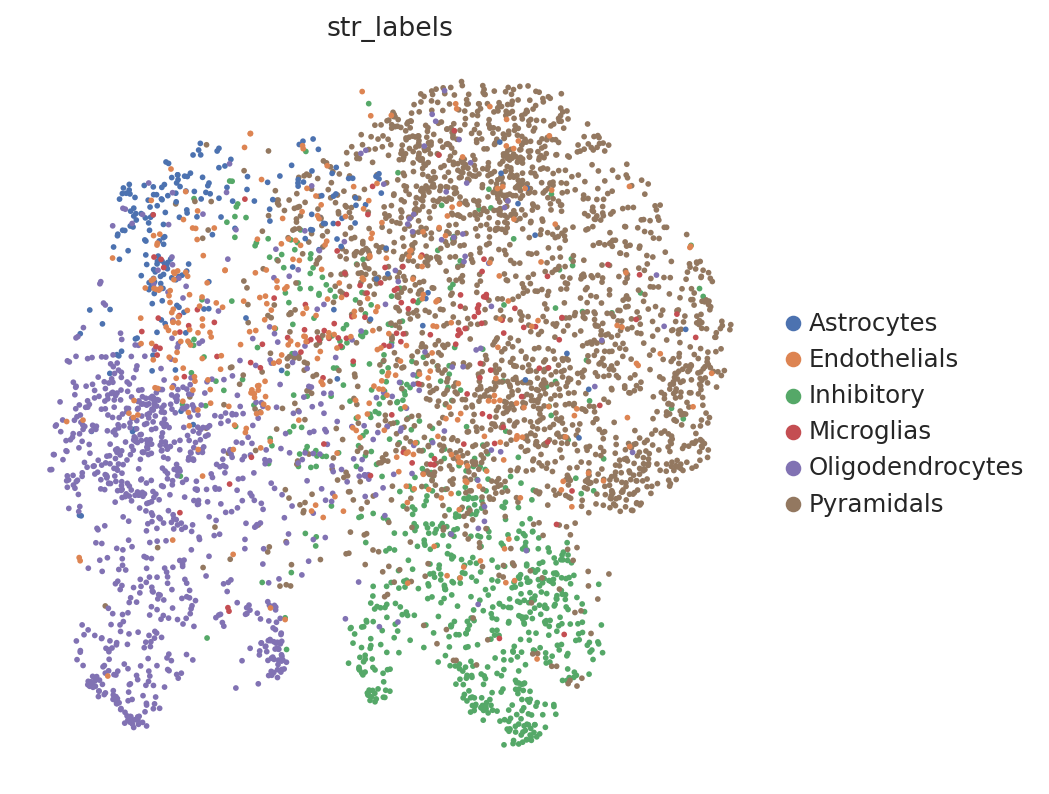

In [11]:
# umap of spatial dataset
sc.pl.umap(spatial_data, color="str_labels")

### Getting Imputation Score

imputation_score() returns the median spearman r correlation over all the cells

In [12]:
# utility function for scoring the imputation


def imputation_score(model, data_spatial, gene_ids_test, normalized=True):
    _, fish_imputation = model.get_imputed_values(normalized=normalized)
    original, imputed = (
        data_spatial.X[:, gene_ids_test],
        fish_imputation[:, gene_ids_test],
    )

    if normalized:
        original = original / data_spatial.X.sum(axis=1).reshape(-1, 1)

    spearman_gene = []
    for g in range(imputed.shape[1]):
        if np.all(imputed[:, g] == 0):
            correlation = 0
        else:
            correlation = spearmanr(original[:, g], imputed[:, g])[0]
        spearman_gene.append(correlation)
    return np.median(np.array(spearman_gene))


imputation_score(model, spatial_data, rand_test_gene_idx, True)

0.2054094104047183

### Plot imputation for *Lamp5*, which should have been hidden in the training

/tmp/ipykernel_153/3711282922.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return x[ind], y[ind], z[ind]


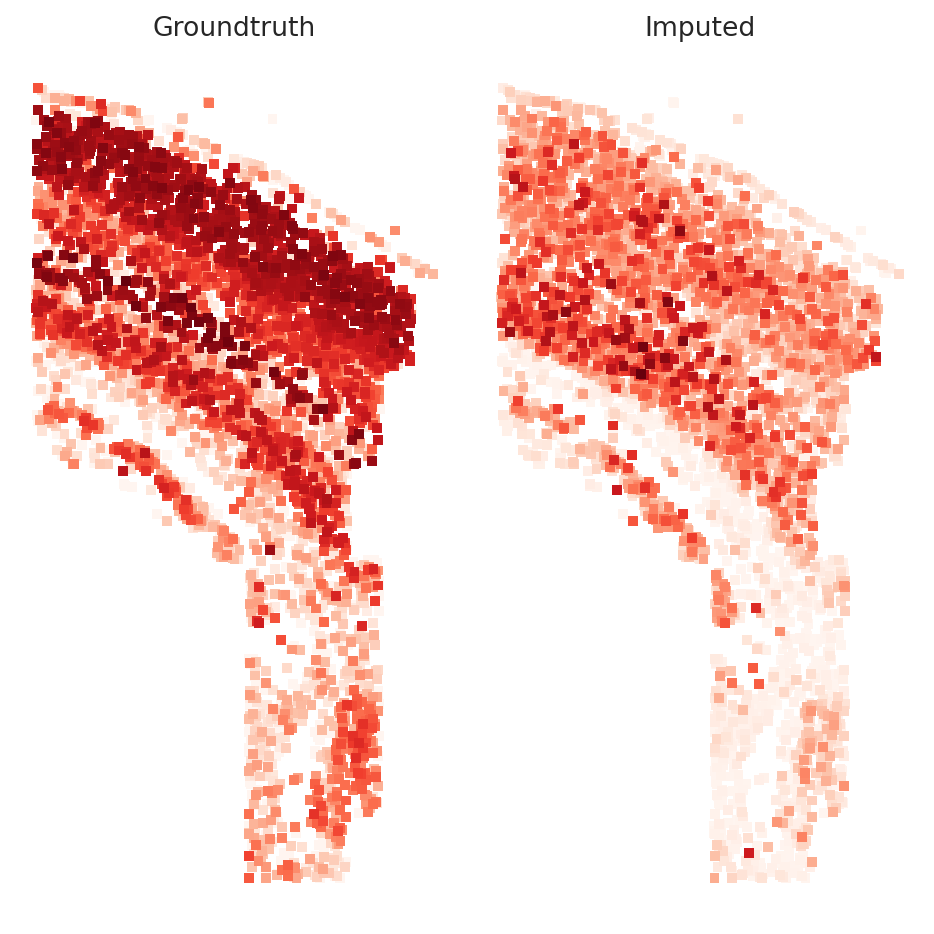

In [13]:
def plot_gene_spatial(model, data_spatial, gene):
    data_seq = model.adatas[0]
    data_fish = data_spatial

    fig, (ax_gt, ax) = plt.subplots(1, 2)

    if isinstance(gene, str):
        gene_id = list(data_seq.gene_names).index(gene)
    else:
        gene_id = gene

    x_coord = data_fish.obs["x_coord"]
    y_coord = data_fish.obs["y_coord"]

    def order_by_strenght(x, y, z):
        ind = np.argsort(z)
        return x[ind], y[ind], z[ind]

    s = 20

    def transform(data):
        return np.log(1 + 100 * data)

    # Plot groundtruth
    x, y, z = order_by_strenght(
        x_coord, y_coord, data_fish.X[:, gene_id] / (data_fish.X.sum(axis=1) + 1)
    )
    ax_gt.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax_gt.set_title("Groundtruth")
    ax_gt.axis("off")

    _, imputed = model.get_imputed_values(normalized=True)
    x, y, z = order_by_strenght(x_coord, y_coord, imputed[:, gene_id])
    ax.scatter(x, y, c=transform(z), s=s, edgecolors="none", marker="s", cmap="Reds")
    ax.set_title("Imputed")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


assert "Lamp5" in rand_test_genes
plot_gene_spatial(model, spatial_data, 9)